In [2]:
import matplotlib.pyplot as plt
import numpy as np
import logging
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from time import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import random

# 0) Load data

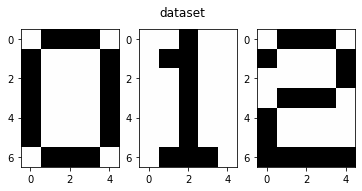

In [74]:
def load_image(img_path):
    img = Image.open(img_path)
    img.load()
    data = np.asarray(img, dtype="int32" )
    data = np.mean(data, axis=-1)  # RGB -> Grayscale
    data[data < 127] = -1
    data[data >= 127] = 1  # Bipolar
    data = data.flatten()
    return data

def draw_image(np_array):
    image = (np_array.reshape(7, 5) + 1) * 127
    img = Image.fromarray(image)
    plt.imshow(img)
    
def draw_images(arrays, title=""):
    for i in range(len(arrays)):
        plt.subplot(1, len(arrays), i + 1)
        draw_image(arrays[i])
    plt.suptitle(title, y=0.82)
    plt.show()

dataset = []
for i in range(1, 4, 1):
    dataset.append(load_image(f"Images_Q2/Image_{i}.png"))
dataset = np.array(dataset)
draw_images(dataset, title="dataset")

# 1)

In [75]:
class ModifiedHebbTrainer:
    def __init__(self, input_size: int, output_size: int, modified=False):
        self.weights = np.zeros((input_size, output_size))
        self.modified = modified

    def train(self, inputs, outputs):
        for i, o in zip(inputs, outputs):
            i = i.reshape(1, -1)
            o = o.reshape(1, -1)
            self.weights += i.T @ o
        # Modification
        if self.modified:
            np.fill_diagonal(self.weights, 0)
    
    def predict(self, i):
        i = i.reshape(1, -1)
        pred = (i @ self.weights).reshape(-1)
        pred[pred > 0] = 1
        pred[pred < 0] = -1
        return pred
    
    def draw_weights(self):
        mat = self.weights
        plt.matshow(mat, cmap=plt.cm.hot, fignum=False)
        for (x, y), value in np.ndenumerate(mat.T):
            plt.text(x, y, f"{value:.0f}", va="center", ha="center", color="green")
        plt.title(f"Hebb Modifed = {self.modified}")

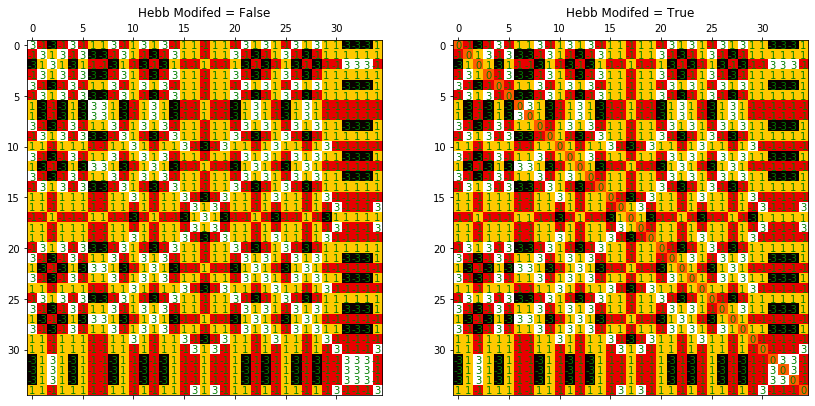

In [76]:
hebb = ModifiedHebbTrainer(dataset.shape[1], dataset.shape[1], modified=False)
hebb.train(dataset, dataset)

modified_hebb = ModifiedHebbTrainer(dataset.shape[1], dataset.shape[1], modified=True)
modified_hebb.train(dataset, dataset)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
hebb.draw_weights()
plt.subplot(1, 2, 2)
modified_hebb.draw_weights()

# 2)

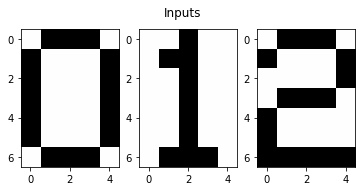

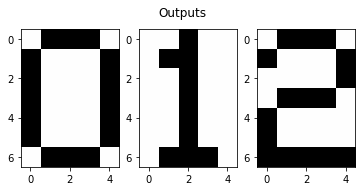

In [77]:
preds = [modified_hebb.predict(d) for d in dataset]
draw_images(dataset, title="Inputs")
draw_images(preds, title="Outputs")

# 3) Noise

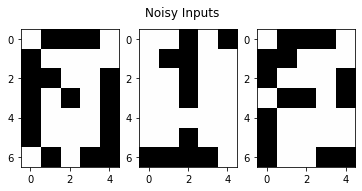

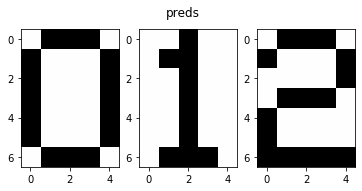

(100000, 3)
Noise 20.0% - Average Accuracy (over 100000 runs): [90.18 95.88 89.79]% -> 91.95


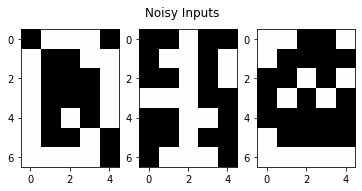

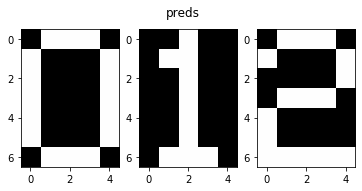

(100000, 3)
Noise 80.0% - Average Accuracy (over 100000 runs): [0. 0. 0.]% -> 0.00


In [78]:
def add_noise(array, noise_ratio=0.2):
    array = np.copy(array)
    for i in range(len(array)):
        for j in range(len(array[i])):
            if random.random() < noise_ratio:
                array[i][j] *= -1
    return array

def is_equal(true, preds):
    eq = []
    for i in range(len(preds)):
        eq.append(np.array_equal(preds[i], true[i]))
    return eq

def evaluate_noise(noise_ratio, hebb_model, dataset):
    eqs = []
    for i in range(100000):
        noisy_inputs = add_noise(dataset, noise_ratio=noise_ratio)
        preds = [hebb_model.predict(i) for i in noisy_inputs]
        eqs.append(is_equal(dataset, preds))
    draw_images(noisy_inputs, title="Noisy Inputs")
    draw_images(preds, title="preds")
    print(np.array(eqs).shape)
    class_acc = np.floor(np.sum(eqs, axis=0) / len(eqs) * 10000) / 100
    print(f"Noise {noise_ratio * 100}% - Average Accuracy (over 100000 runs): {class_acc}% -> {np.mean(class_acc):.2f}")

evaluate_noise(0.2, hebb, dataset)
evaluate_noise(0.8, hebb, dataset)

# 4) Loss

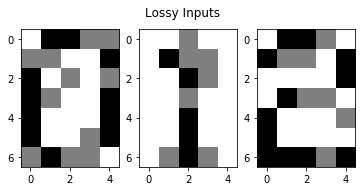

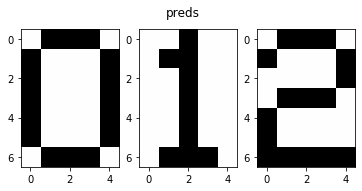

Loss 20.0% - Average Accuracy (over 100000 runs): [ 99.996 100.     99.984]%


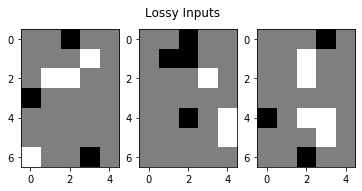

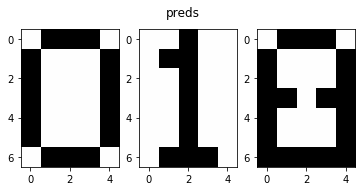

Loss 80.0% - Average Accuracy (over 100000 runs): [74.319 84.353 69.003]%


In [9]:
def add_loss(array, loss_ratio=0.2):
    array = np.copy(array)
    for i in range(len(array)):
        for j in range(len(array[i])):
            if random.random() < loss_ratio:
                array[i][j] = 0
    return array

def evaluate_loss(loss_ratio, hebb_model, dataset):
    eqs = []
    for i in range(100000):
        lossy_inputs = add_loss(dataset, loss_ratio)
        preds = [hebb_model.predict(i) for i in lossy_inputs]
        eqs.append(is_equal(dataset, preds))
    draw_images(lossy_inputs, title="Lossy Inputs")
    draw_images(preds, title="preds")
    class_acc = np.sum(eqs, axis=0) / len(eqs)
    print(f"Loss {loss_ratio * 100}% - Average Accuracy (over 100000 runs): {class_acc*100}%")

evaluate_loss(0.2, hebb, dataset)
evaluate_loss(0.8, hebb, dataset)
# evaluate_loss(0.2, modified_hebb, dataset)
# evaluate_loss(0.8, modified_hebb, dataset)

# 5) Bonus: Pseudo-inverse learning rule

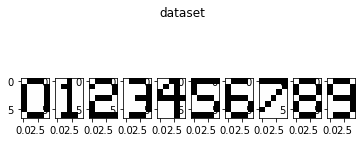

In [79]:
dataset = []
for i in range(1, 11, 1):
    dataset.append(load_image(f"Extra/Image_{i}.png"))
dataset = np.array(dataset)
draw_images(dataset, title="dataset")

In [80]:
hebb = ModifiedHebbTrainer(dataset.shape[1], dataset.shape[1], modified=False)
hebb.train(dataset, dataset)

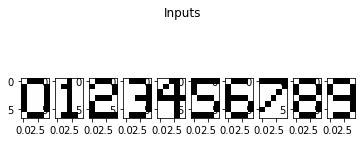

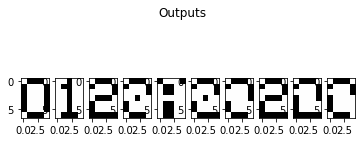

In [121]:
preds = [modified_hebb.predict(d) for d in dataset]
draw_images(dataset, title="Inputs")
draw_images(preds, title="Outputs")

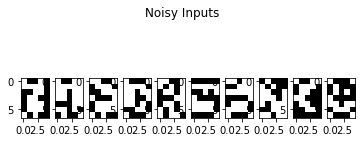

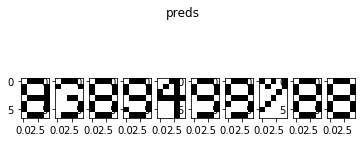

(100000, 10)
Noise 20.0% - Average Accuracy (over 100000 runs): [ 0.3  26.02  0.26  0.89 24.81  0.51  0.39 18.2  83.99 24.43]% -> 17.98


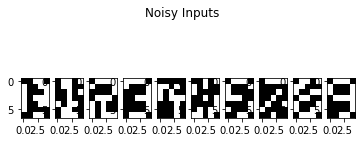

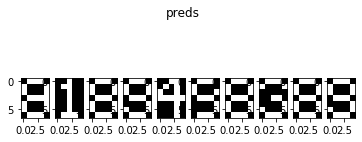

(100000, 10)
Noise 80.0% - Average Accuracy (over 100000 runs): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]% -> 0.00


In [89]:
evaluate_noise(0.2, hebb, dataset)
evaluate_noise(0.8, hebb, dataset)

In [117]:
class PseudoInverseHebbTrainer:
    def __init__(self, input_size: int, output_size: int):
        self.weights = np.zeros((input_size, output_size))

    def train(self, inputs, outputs):
        self.weights = np.linalg.pinv(inputs) @ outputs
    
    def predict(self, i):
        i = i.reshape(1, -1)
        pred = (i @ self.weights).reshape(-1)
        pred[pred > 0] = 1
        pred[pred < 0] = -1
        return pred
    
    def draw_weights(self):
        mat = self.weights
        plt.matshow(mat, cmap=plt.cm.hot, fignum=False)
        for (x, y), value in np.ndenumerate(mat.T):
            plt.text(x, y, f"{value:.0f}", va="center", ha="center", color="green")
        plt.title(f"Hebb Modifed = {self.modified}")

In [118]:
pinv = PseudoInverseHebbTrainer(dataset.shape[1], dataset.shape[1])
pinv.train(dataset, dataset)

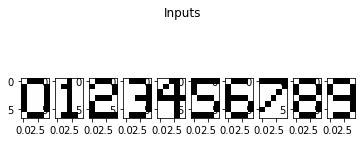

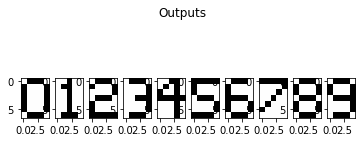

In [120]:
preds = [pinv.predict(d) for d in dataset]
draw_images(dataset, title="Inputs")
draw_images(preds, title="Outputs")

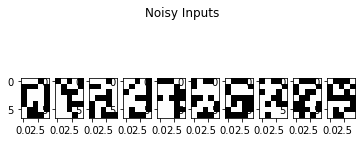

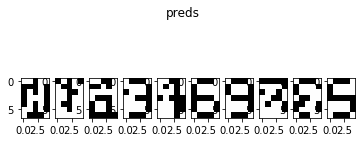

(100000, 10)
Noise 20.0% - Average Accuracy (over 100000 runs): [19.57 18.72 21.9  23.04 20.19 20.61 23.8  17.81 24.01 23.94]% -> 21.36


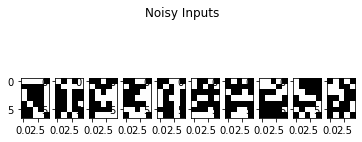

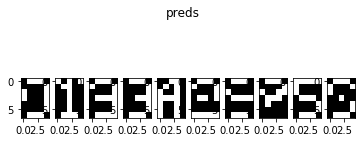

(100000, 10)
Noise 80.0% - Average Accuracy (over 100000 runs): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]% -> 0.00


In [119]:
evaluate_noise(0.2, pinv, dataset)
evaluate_noise(0.8, pinv, dataset)